# Setup Environment

In [1]:
import math, os, re, time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import shap

from tqdm.notebook import tqdm

%matplotlib inline
tqdm.pandas()

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/GiveMeSomeCredit/Data Dictionary.xls
/kaggle/input/GiveMeSomeCredit/cs-training.csv
/kaggle/input/GiveMeSomeCredit/sampleEntry.csv
/kaggle/input/GiveMeSomeCredit/cs-test.csv


# Load Data

In [2]:
train = pd.read_csv('/kaggle/input/GiveMeSomeCredit/cs-training.csv', index_col=0)
test = pd.read_csv('/kaggle/input/GiveMeSomeCredit/cs-test.csv', index_col=0)

renamed = {'SeriousDlqin2yrs':'default_occurred',
           'RevolvingUtilizationOfUnsecuredLines':'utilization_of_unsecured_loc',
           'NumberOfTime30-59DaysPastDueNotWorse':'30_to_59_days_pastdue_count',
           'DebtRatio':'debt_ratio',
           'MonthlyIncome':'monthly_income',
           'NumberOfOpenCreditLinesAndLoans':'open_loc_and_loan_count',
           'NumberOfTimes90DaysLate':'90_days_late_count',
           'NumberRealEstateLoansOrLines':'re_loans_and_lines_count',
           'NumberOfTime60-89DaysPastDueNotWorse':'60_to_89_days_pastdue_count',
           'NumberOfDependents':'dependents'}

train.rename(columns=renamed, inplace=True)
test.rename(columns=renamed, inplace=True)

train

,default_occurred,utilization_of_unsecured_loc,age,30_to_59_days_pastdue_count,debt_ratio,monthly_income,open_loc_and_loan_count,90_days_late_count,re_loans_and_lines_count,60_to_89_days_pastdue_count,dependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


# Data Cleaning & Feature Engineering

## Fill 'dependents' NaN values with 0

In [3]:
train['dependents'].fillna(value=0, inplace=True)
train['dependents'] = train['dependents'].apply(int)

test['dependents'].fillna(value=0, inplace=True)
test['dependents'] = test['dependents'].apply(int)

train

,default_occurred,utilization_of_unsecured_loc,age,30_to_59_days_pastdue_count,debt_ratio,monthly_income,open_loc_and_loan_count,90_days_late_count,re_loans_and_lines_count,60_to_89_days_pastdue_count,dependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0
149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2
149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0
149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0


## Binning and One-Hot Encoding Income Levels

In [4]:
def income_binned(data):
    # Level 0 = NaN income values
    if np.isnan(data):
        return 0
    
    # Level 1 = 0 to 20k
    elif data <= 20000:
        return 1
    
    # Level 2 = 20k to 40k
    elif data <= 40000:
        return 2
    
    # Level 3 = 40k to 60k
    elif data <= 60000:
        return 3
    
    # Level 4 = 60k to 80k
    elif data <= 80000:
        return 4
    
    # Level 5 = 80k to 100k
    elif data <= 100000:
        return 5
    
    # Level 6 = Above 100k
    else:
        return 6

In [5]:
# Binning Income Levels 
train['monthly_income_binned'] = train['monthly_income'].apply(income_binned)
test['monthly_income_binned'] = test['monthly_income'].apply(income_binned)

# Dropping original Income Levels
train.drop(columns=['monthly_income'], inplace=True)
test.drop(columns=['monthly_income'], inplace=True)

# Creating Income Level dummy variables
dummy_names = ['monthly_income_binned_' + str(i) for i in range(1,7)]

one_hot_encoded = pd.get_dummies(train['monthly_income_binned'], drop_first=True)
one_hot_encoded.columns = dummy_names

train = pd.concat([train, one_hot_encoded], axis=1)

one_hot_encoded = pd.get_dummies(test['monthly_income_binned'], drop_first=True)
one_hot_encoded.columns = dummy_names

test = pd.concat([test, one_hot_encoded], axis=1)

# Drop binned incomes after creating dummy variables
train.drop(columns=['monthly_income_binned'], inplace=True)
test.drop(columns=['monthly_income_binned'], inplace=True)

train

,default_occurred,utilization_of_unsecured_loc,age,30_to_59_days_pastdue_count,debt_ratio,open_loc_and_loan_count,90_days_late_count,re_loans_and_lines_count,60_to_89_days_pastdue_count,dependents,monthly_income_binned_1,monthly_income_binned_2,monthly_income_binned_3,monthly_income_binned_4,monthly_income_binned_5,monthly_income_binned_6
1,1,0.766127,45,2,0.802982,13,0,6,0,2,1,0,0,0,0,0
2,0,0.957151,40,0,0.121876,4,0,0,0,1,1,0,0,0,0,0
3,0,0.658180,38,1,0.085113,2,1,0,0,0,1,0,0,0,0,0
4,0,0.233810,30,0,0.036050,5,0,0,0,0,1,0,0,0,0,0
5,0,0.907239,49,1,0.024926,7,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,0,0.040674,74,0,0.225131,4,0,1,0,0,1,0,0,0,0,0
149997,0,0.299745,44,0,0.716562,4,0,1,0,2,1,0,0,0,0,0
149998,0,0.246044,58,0,3870.000000,18,0,1,0,0,0,0,0,0,0,0
149999,0,0.000000,30,0,0.000000,4,0,0,0,0,1,0,0,0,0,0


## Aggregate Past Due Counts

In [6]:
train['above_30_days_pastdue_count'] = train['30_to_59_days_pastdue_count'] + train['60_to_89_days_pastdue_count'] + train['90_days_late_count']
train.drop(columns=['30_to_59_days_pastdue_count',
                    '60_to_89_days_pastdue_count',
                    '90_days_late_count'], inplace=True)

test['above_30_days_pastdue_count'] = test['30_to_59_days_pastdue_count'] + test['60_to_89_days_pastdue_count'] + test['90_days_late_count']
test.drop(columns=['30_to_59_days_pastdue_count',
                   '60_to_89_days_pastdue_count',
                   '90_days_late_count'], inplace=True)

train

,default_occurred,utilization_of_unsecured_loc,age,debt_ratio,open_loc_and_loan_count,re_loans_and_lines_count,dependents,monthly_income_binned_1,monthly_income_binned_2,monthly_income_binned_3,monthly_income_binned_4,monthly_income_binned_5,monthly_income_binned_6,above_30_days_pastdue_count
1,1,0.766127,45,0.802982,13,6,2,1,0,0,0,0,0,2
2,0,0.957151,40,0.121876,4,0,1,1,0,0,0,0,0,0
3,0,0.658180,38,0.085113,2,0,0,1,0,0,0,0,0,2
4,0,0.233810,30,0.036050,5,0,0,1,0,0,0,0,0,0
5,0,0.907239,49,0.024926,7,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,0,0.040674,74,0.225131,4,1,0,1,0,0,0,0,0,0
149997,0,0.299745,44,0.716562,4,1,2,1,0,0,0,0,0,0
149998,0,0.246044,58,3870.000000,18,1,0,0,0,0,0,0,0,0
149999,0,0.000000,30,0.000000,4,0,0,1,0,0,0,0,0,0


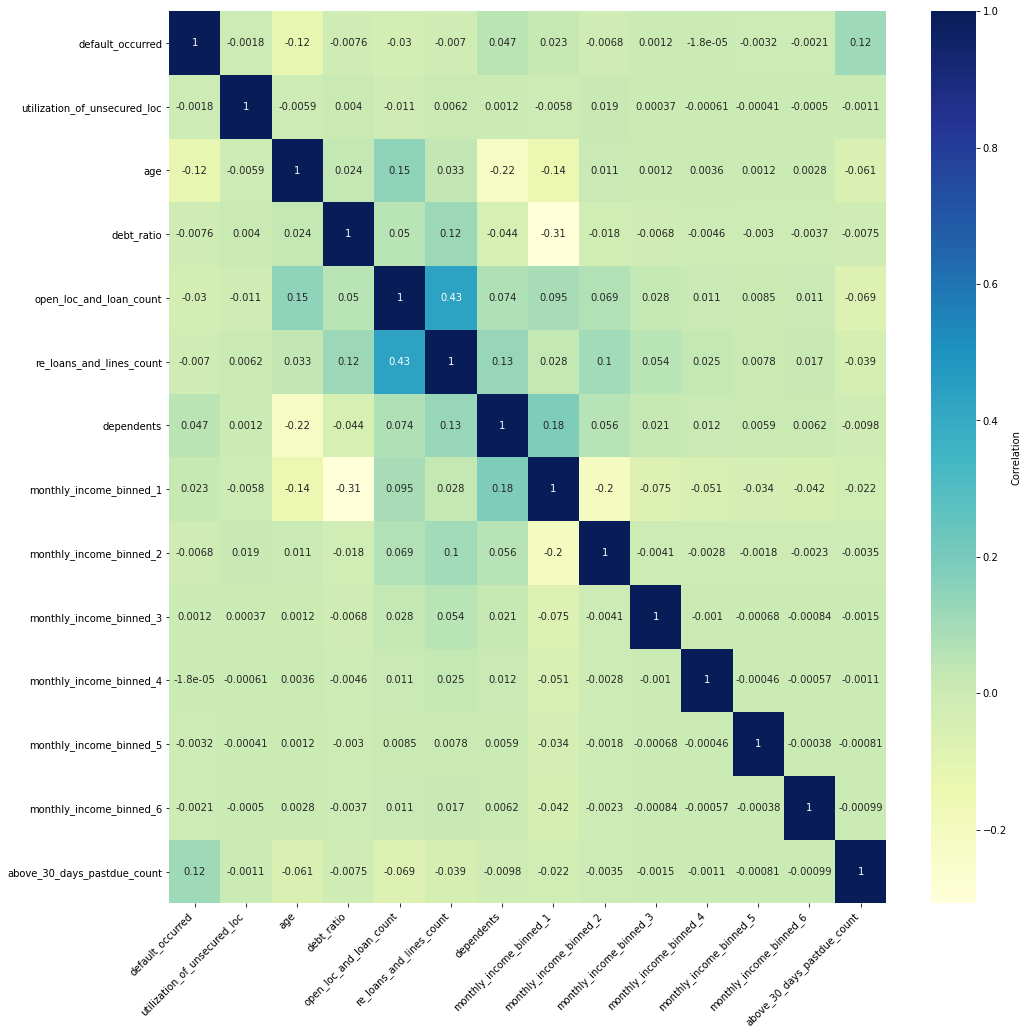

<Figure size 432x288 with 0 Axes>

In [7]:
# Correlation Matrix (Heatmap)
corr = train.corr(method='pearson')

plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap="YlGnBu",cbar_kws={'label': 'Correlation'})
plt.tight_layout()
plt.xticks(rotation=45, horizontalalignment='right')
plt.yticks(rotation=0)

plt.show()
plt.clf()

# Resampling (for Imbalanced Dataset)

In [8]:
X_train = train.iloc[:,1:]
y_train = train.iloc[:,0:1]

X_test = test.iloc[:,1:]
y_test = test.iloc[:,0:1]

X_train

,utilization_of_unsecured_loc,age,debt_ratio,open_loc_and_loan_count,re_loans_and_lines_count,dependents,monthly_income_binned_1,monthly_income_binned_2,monthly_income_binned_3,monthly_income_binned_4,monthly_income_binned_5,monthly_income_binned_6,above_30_days_pastdue_count
1,0.766127,45,0.802982,13,6,2,1,0,0,0,0,0,2
2,0.957151,40,0.121876,4,0,1,1,0,0,0,0,0,0
3,0.658180,38,0.085113,2,0,0,1,0,0,0,0,0,2
4,0.233810,30,0.036050,5,0,0,1,0,0,0,0,0,0
5,0.907239,49,0.024926,7,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,0.040674,74,0.225131,4,1,0,1,0,0,0,0,0,0
149997,0.299745,44,0.716562,4,1,2,1,0,0,0,0,0,0
149998,0.246044,58,3870.000000,18,1,0,0,0,0,0,0,0,0
149999,0.000000,30,0.000000,4,0,0,1,0,0,0,0,0,0


In [9]:
y_train

,default_occurred
1,1
2,0
3,0
4,0
5,0
...,...
149996,0
149997,0
149998,0
149999,0


<AxesSubplot:xlabel='default_occurred', ylabel='count'>

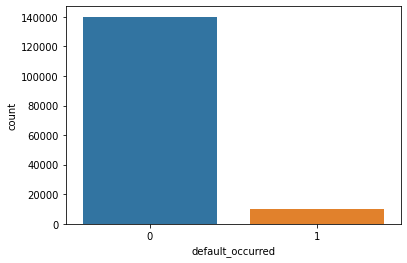

In [10]:
sns.countplot(x='default_occurred',data=y_train)

In [11]:
smote = SMOTE(sampling_strategy=30/70, random_state=42, n_jobs=-1)
X_train, y_train = smote.fit_resample(X_train, y_train)

<AxesSubplot:xlabel='default_occurred', ylabel='count'>

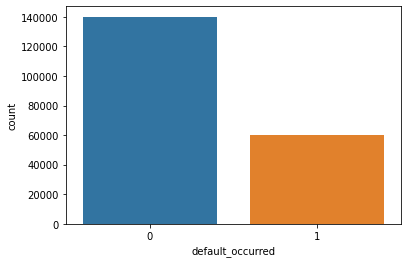

In [12]:
sns.countplot(x='default_occurred',data=y_train)

# Feature Scaling

In [13]:
X_train = pd.concat([X_train.iloc[:,:6],
                     X_train.iloc[:,-1],
                     X_train.iloc[:,6:-1]],axis=1)
X_test = pd.concat([X_test.iloc[:,:6],
                    X_test.iloc[:,-1],
                    X_test.iloc[:,6:-1]],axis=1)

X_train

,utilization_of_unsecured_loc,age,debt_ratio,open_loc_and_loan_count,re_loans_and_lines_count,dependents,above_30_days_pastdue_count,monthly_income_binned_1,monthly_income_binned_2,monthly_income_binned_3,monthly_income_binned_4,monthly_income_binned_5,monthly_income_binned_6
0,0.766127,45,0.802982,13,6,2,2,1,0,0,0,0,0
1,0.957151,40,0.121876,4,0,1,0,1,0,0,0,0,0
2,0.658180,38,0.085113,2,0,0,2,1,0,0,0,0,0
3,0.233810,30,0.036050,5,0,0,0,1,0,0,0,0,0
4,0.907239,49,0.024926,7,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199957,0.190622,46,0.619681,7,3,1,0,1,0,0,0,0,0
199958,0.857933,41,0.420276,8,2,3,0,1,0,0,0,0,0
199959,0.742482,39,0.824229,5,3,1,1,1,0,0,0,0,0
199960,0.268865,46,0.333230,4,2,3,0,1,0,0,0,0,0


In [14]:
X_test

,utilization_of_unsecured_loc,age,debt_ratio,open_loc_and_loan_count,re_loans_and_lines_count,dependents,above_30_days_pastdue_count,monthly_income_binned_1,monthly_income_binned_2,monthly_income_binned_3,monthly_income_binned_4,monthly_income_binned_5,monthly_income_binned_6
1,0.885519,43,0.177513,4,0,0,0,1,0,0,0,0,0
2,0.463295,57,0.527237,15,4,2,0,1,0,0,0,0,0
3,0.043275,59,0.687648,12,1,2,0,1,0,0,0,0,0
4,0.280308,38,0.925961,7,2,0,1,1,0,0,0,0,0
5,1.000000,27,0.019917,4,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101499,0.282653,24,0.068522,5,0,0,0,1,0,0,0,0,0
101500,0.922156,36,0.934217,8,2,4,3,1,0,0,0,0,0
101501,0.081596,70,836.000000,3,0,0,0,0,0,0,0,0,0
101502,0.335457,56,3568.000000,8,2,3,1,0,0,0,0,0,0


In [15]:
scaler = StandardScaler()
scale_vars = X_train.loc[:,:'above_30_days_pastdue_count'].columns

# Fit and Scale X_train
scaled = pd.DataFrame(scaler.fit_transform(X_train.loc[:,:'above_30_days_pastdue_count'].copy()), columns=scale_vars, index=X_train.index)
X_train = pd.concat([scaled,X_train.loc[:,'monthly_income_binned_1':]], axis=1)

# Scale X_var using the X_train fitted scaler (prevents data leakage)
scaled = pd.DataFrame(scaler.transform(X_test.loc[:,:'above_30_days_pastdue_count'].copy()), columns=scale_vars, index=X_test.index)
X_test = pd.concat([scaled,X_test.loc[:,'monthly_income_binned_1':]], axis=1)

X_train

,utilization_of_unsecured_loc,age,debt_ratio,open_loc_and_loan_count,re_loans_and_lines_count,dependents,above_30_days_pastdue_count,monthly_income_binned_1,monthly_income_binned_2,monthly_income_binned_3,monthly_income_binned_4,monthly_income_binned_5,monthly_income_binned_6
0,-0.021102,-0.386559,-0.181406,0.908049,4.345360,1.155894,-0.007472,1,0,0,0,0,0
1,-0.020242,-0.730213,-0.181772,-0.810132,-0.831162,0.241638,-0.105573,1,0,0,0,0,0
2,-0.021588,-0.867675,-0.181792,-1.191950,-0.831162,-0.672618,-0.007472,1,0,0,0,0,0
3,-0.023499,-1.417521,-0.181819,-0.619223,-0.831162,-0.672618,-0.105573,1,0,0,0,0,0
4,-0.020467,-0.111636,-0.181824,-0.237405,0.031591,-0.672618,-0.056522,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199957,-0.023693,-0.317828,-0.181505,-0.237405,1.757099,0.241638,-0.105573,1,0,0,0,0,0
199958,-0.020689,-0.661482,-0.181612,-0.046496,0.894345,2.070151,-0.105573,1,0,0,0,0,0
199959,-0.021209,-0.798944,-0.181395,-0.619223,1.757099,0.241638,-0.056522,1,0,0,0,0,0
199960,-0.023341,-0.317828,-0.181659,-0.810132,0.894345,2.070151,-0.105573,1,0,0,0,0,0


In [16]:
X_test

,utilization_of_unsecured_loc,age,debt_ratio,open_loc_and_loan_count,re_loans_and_lines_count,dependents,above_30_days_pastdue_count,monthly_income_binned_1,monthly_income_binned_2,monthly_income_binned_3,monthly_income_binned_4,monthly_income_binned_5,monthly_income_binned_6
1,-0.020565,-0.524021,-0.181742,-0.810132,-0.831162,-0.672618,-0.105573,1,0,0,0,0,0
2,-0.022466,0.438211,-0.181554,1.289867,2.619853,1.155894,-0.105573,1,0,0,0,0,0
3,-0.024357,0.575673,-0.181468,0.717140,0.031591,1.155894,-0.105573,1,0,0,0,0,0
4,-0.023289,-0.867675,-0.181340,-0.237405,0.894345,-0.672618,-0.056522,1,0,0,0,0,0
5,-0.020049,-1.623714,-0.181827,-0.810132,-0.831162,0.241638,-0.105573,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101499,-0.023279,-1.829906,-0.181801,-0.619223,-0.831162,-0.672618,-0.105573,1,0,0,0,0,0
101500,-0.020400,-1.005136,-0.181336,-0.046496,0.894345,2.984407,0.041579,1,0,0,0,0,0
101501,-0.024184,1.331712,0.267708,-1.001041,-0.831162,-0.672618,-0.105573,0,0,0,0,0,0
101502,-0.023041,0.369480,1.736799,-0.046496,0.894345,2.070151,-0.056522,0,0,0,0,0,0


# Final Modelling (Training & Prediction)

In [17]:
best_model = XGBClassifier(n_estimators=100,
                           learning_rate=0.05,
                           objective='binary:logistic',
                           max_depth=5,
                           subsample=0.9, 
                           reg_alpha=0.01,
                           reg_lambda=0.5,
                           use_label_encoder=False,
                           n_jobs=-1, 
                           random_state=42)
best_model.fit(X_train, y_train.values.ravel())

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

[05:54:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


# Saving Output

In [18]:
ids = np.arange(1,101504)
submission = pd.DataFrame({'Id': ids, 
                           'Probability': y_proba})
submission.to_csv("/kaggle/working/credit_score_submision.csv", index=False)

# Feature Importance (SHAP)

In [19]:
# DF, based on which importance is checked
X_importance = X_train

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_importance)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


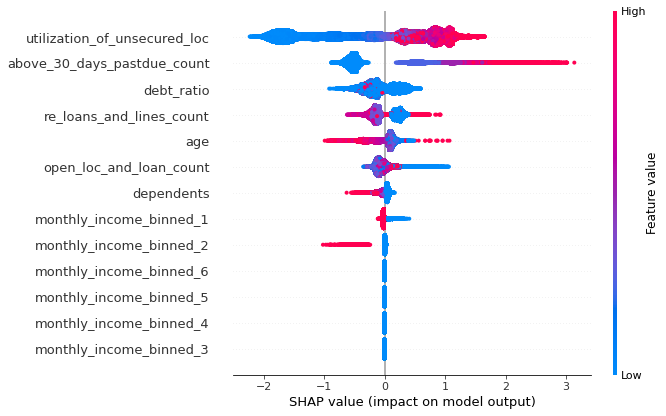

In [20]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

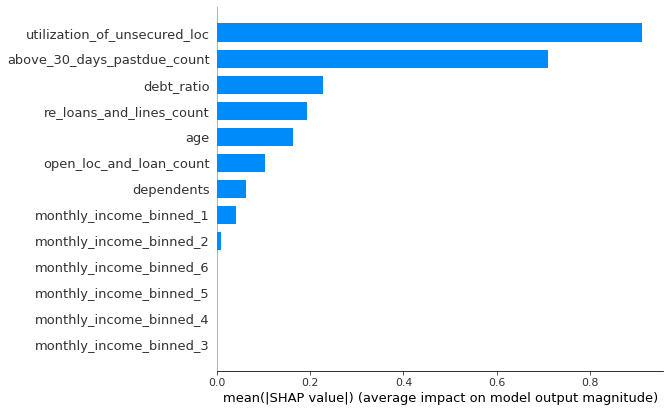

In [21]:
shap.summary_plot(shap_values, X_importance, plot_type='bar')